In [53]:
import pandas as pd
import scipy
import re
import sys

sys.path.append('../lib')

import mongoToken

In [51]:
data = pd.read_csv("../Dataset/final.csv")
data.head()

,t,filter_str,docUUID,denamed,FindCollectionTarget,FindCollectionTargetdeNamed,queryLength,ipHash,port,whereDetected,regexDetected,emptyFilter,nullArgument,logicOperator,db,denamedDb,nreturned,cpuNanos,label,planningTimeMicros
0,1.712243e+09,"{'user': '{}', 'password': '{}'}",e5e23d7e-5367-4829-a104-ca369c49d4dc,"{'name': '{}', 'name': '{}'}",test_collection,test_collection,32,2130706433,47038,0,0,0,1,0,test_database,test_database,0.0,176371,0.0,83.0
1,1.712243e+09,"{'user': '{}', 'password': '{}'}",e5e23d7e-5367-4829-a104-ca369c49d4dc,"{'name': '{}', 'name': '{}'}",test_collection,test_collection,32,2130706433,47038,0,0,0,1,0,test_database,test_database,0.0,176371,0.0,83.0
2,1.712243e+09,{'username': {'$regex': '^{}'}},e5e23d7e-5367-4829-a104-ca369c49d4dc,{'name': {'$regex': '^{}'}},test_collection,test_collection,31,2130706433,47038,0,1,0,1,0,test_database,test_database,0.0,112781,1.0,71.0
3,1.712243e+09,{'username': {'$regex': '^{}'}},e5e23d7e-5367-4829-a104-ca369c49d4dc,{'name': {'$regex': '^{}'}},test_collection,test_collection,31,2130706433,47038,0,1,0,1,0,test_database,test_database,0.0,112781,1.0,71.0
4,1.712243e+09,{'username': {'$ne': '{}'}},e5e23d7e-5367-4829-a104-ca369c49d4dc,{'name': {'$ne': '{}'}},test_collection,test_collection,27,2130706433,47038,0,0,0,1,1,test_database,test_database,0.0,71093,1.0,42.0


In [48]:
import re

def custom_tokenizer(query_string):
    tokens = []
    i = 0
    while i < len(query_string):
        # Skip leading and trailing double quotes
        if query_string[i] == '"':
            i += 1
            continue

        # Check for words with only alphabets
        match = re.match(r'\b[a-zA-Z]+\b', query_string[i:])
        if match:
            tokens.append(match.group())
            i += len(match.group())
            continue

        # Check for words with a leading '$' and only alphabets
        match = re.match(r'\$[a-zA-Z]+', query_string[i:])
        if match:
            tokens.append(match.group())
            i += len(match.group())
            continue

        # Check for '{' and '}' and handle nested quotes
        if query_string[i] == '{':
            if query_string[i+1] == '"':
                j = query_string.find('"', i+2)
                if j != -1:
                    tokens.append(query_string[i:j+1])
                    i = j + 1
                    continue
            tokens.append('{')
            i += 1
        elif query_string[i] == '}':
            if len(tokens) > 0 and tokens[-1] == '{':
                tokens[-1] = '{}'
            else:
                tokens.append('}')
            i += 1
            continue

        # Check for operators
        match = re.match(r'[\+\\\:]', query_string[i:])
        if match:
            tokens.append(match.group())
            i += len(match.group())
            continue

        # Check for regex arguments
        if query_string[i] == '/':
            regex_end = query_string.find('/', i + 1)
            if regex_end != -1:
                tokens.append(query_string[i:regex_end + 1])
                i = regex_end + 1
                continue

        # If none of the above conditions match, move to the next character
        i += 1

    return tokens

In [28]:

boolean_columns = ['whereDetected', 'regexDetected', 'emptyFilter', 'nullArgument', 'logicOperator','label']
data[boolean_columns] = data[boolean_columns].astype(bool)
string_columns = ['filter_str', 'docUUID', 'denamed', 'FindCollectionTarget', 'FindCollectionTargetdeNamed', 'db', 'denamedDb']
data[string_columns] = data[string_columns].astype(str)
data.dtypes


t                              float64
filter_str                      object
docUUID                         object
denamed                         object
FindCollectionTarget            object
FindCollectionTargetdeNamed     object
queryLength                      int64
ipHash                           int64
port                             int64
whereDetected                     bool
regexDetected                     bool
emptyFilter                       bool
nullArgument                      bool
logicOperator                     bool
db                              object
denamedDb                       object
nreturned                      float64
cpuNanos                         int64
label                             bool
planningTimeMicros             float64
dtype: object

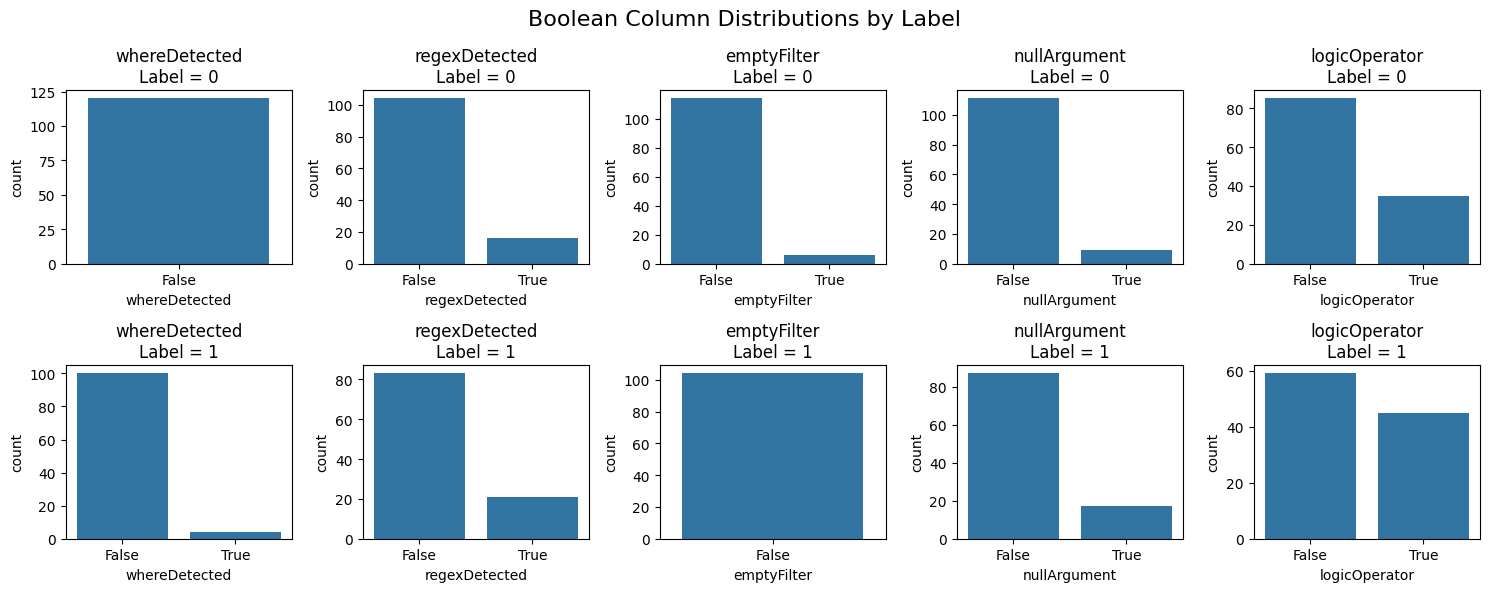

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter data based on label values
df_label_0 = data[data['label'] == 0]
df_label_1 = data[data['label'] == 1]

# Plot boolean columns as subplots
bool_columns = ['whereDetected', 'regexDetected', 'emptyFilter', 'nullArgument', 'logicOperator']
num_cols = len(bool_columns)
num_rows = 2  # One row for each label

fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 3, num_rows * 3))

for i, col in enumerate(bool_columns):
    sns.countplot(x=col, data=df_label_0, ax=axes[0][i])
    axes[0][i].set_title(f'{col}\nLabel = 0')
    sns.countplot(x=col, data=df_label_1, ax=axes[1][i])
    axes[1][i].set_title(f'{col}\nLabel = 1')

# Add subtitles
plt.suptitle('Boolean Column Distributions by Label', fontsize=16)

# Adjust layout
plt.tight_layout()
plt.show()


In [5]:
from scipy.stats import ks_2samp

# Split data by label
data_label_0 = data[data['label'] == 0]['planningTimeMicros']
data_label_1 = data[data['label'] == 1]['planningTimeMicros']

# Perform Kolmogorov-Smirnov test
ks_statistic, p_value = ks_2samp(data_label_0, data_label_1)

from scipy.stats import shapiro

# Perform Shapiro-Wilk test for each group
shapiro_stat_0, p_value_0 = shapiro(data_label_0)
shapiro_stat_1, p_value_1 = shapiro(data_label_1)

# Print p-values
print("Shapiro-Wilk test p-value for data_label_0:", p_value_0)
print("Shapiro-Wilk test p-value for data_label_1:", p_value_1)


Shapiro-Wilk test p-value for data_label_0: 6.437841389541135e-14
Shapiro-Wilk test p-value for data_label_1: 4.567817338668723e-16


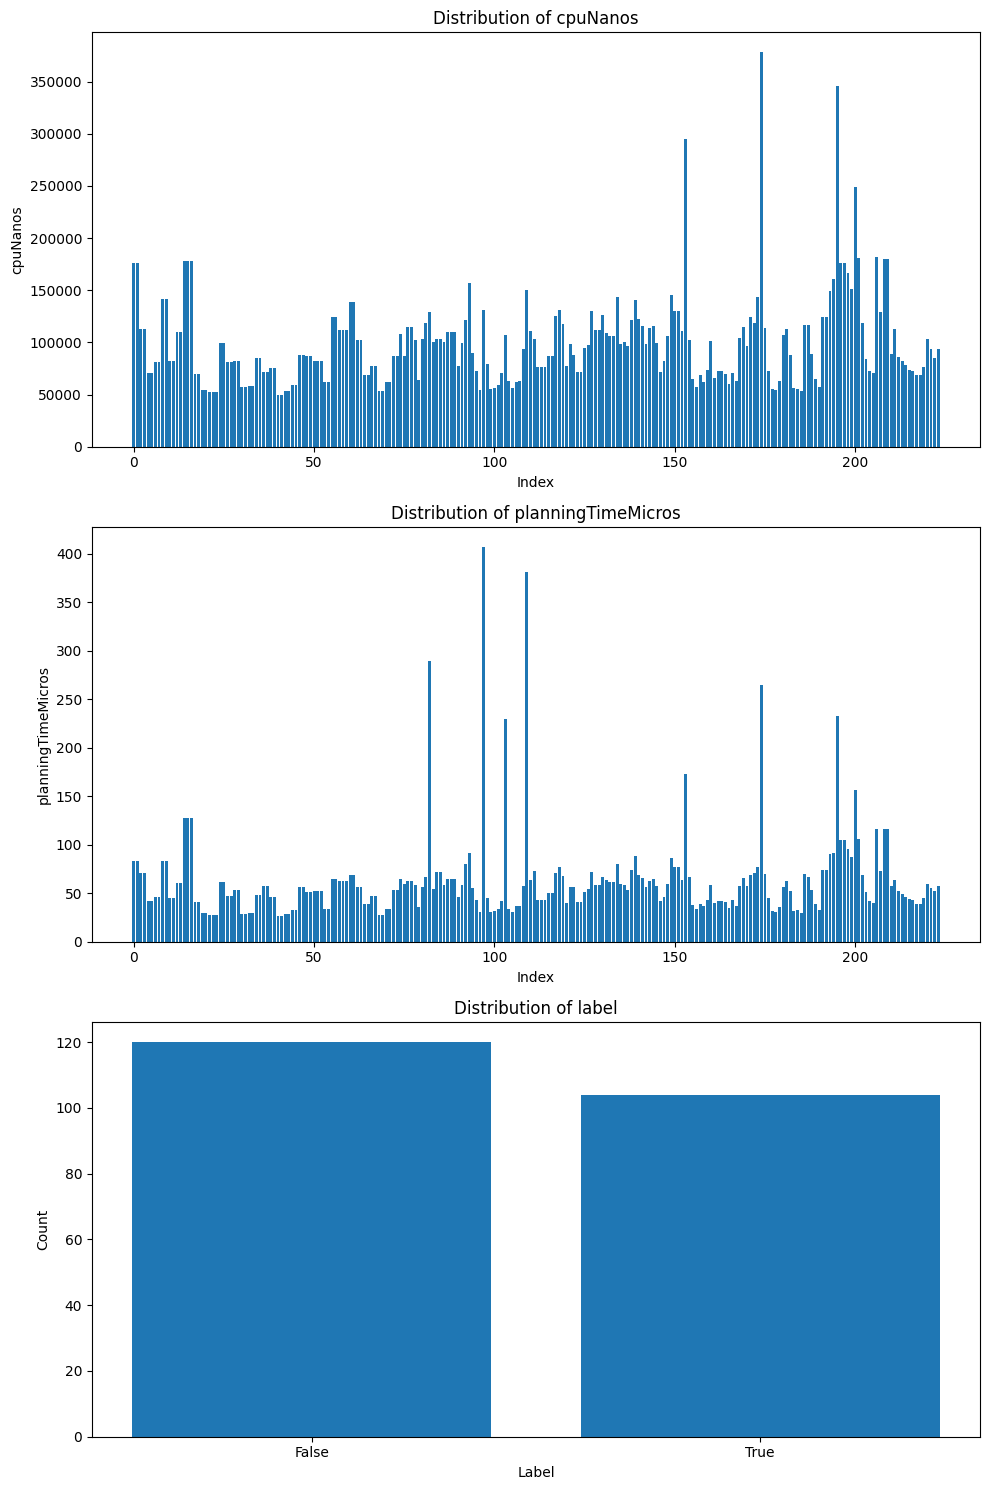

In [7]:
import matplotlib.pyplot as plt

# Assuming 'data' is your DataFrame
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

# Plot distribution of cpuNanos
axs[0].bar(data.index, data['cpuNanos'])
axs[0].set_title('Distribution of cpuNanos')
axs[0].set_xlabel('Index')
axs[0].set_ylabel('cpuNanos')

# Plot distribution of planningTimeMicros
axs[1].bar(data.index, data['planningTimeMicros'])
axs[1].set_title('Distribution of planningTimeMicros')
axs[1].set_xlabel('Index')
axs[1].set_ylabel('planningTimeMicros')

# Plot distribution of label
label_counts = data['label'].value_counts()
axs[2].bar(['False', 'True'], label_counts)
axs[2].set_title('Distribution of label')
axs[2].set_xlabel('Label')
axs[2].set_ylabel('Count')

plt.tight_layout()
plt.show()


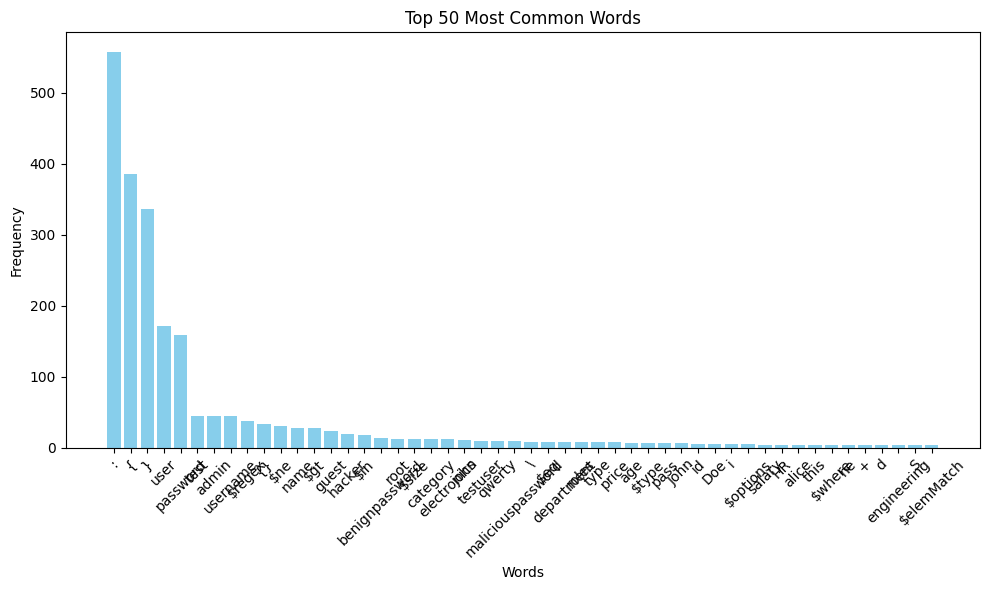

In [49]:
import re
from collections import Counter
import matplotlib.pyplot as plt

word_counts = Counter()
for text in data['filter_str']:
    tokens = custom_tokenizer(text)
    word_counts.update(tokens)

# Convert the word counts to a DataFrame for easier manipulation
word_counts_df = pd.DataFrame.from_dict(word_counts, orient='index', columns=['Frequency'])

# Get the top 50 most common words
top_words = word_counts_df.sort_values(by='Frequency', ascending=False).head(50)

# Plot the top 50 most common words
plt.figure(figsize=(10, 6))
plt.bar(top_words.index, top_words['Frequency'], color='skyblue')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 50 Most Common Words')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Export word frequency data to a CSV file
word_counts_df.to_csv('wordFreq.csv', header=True)

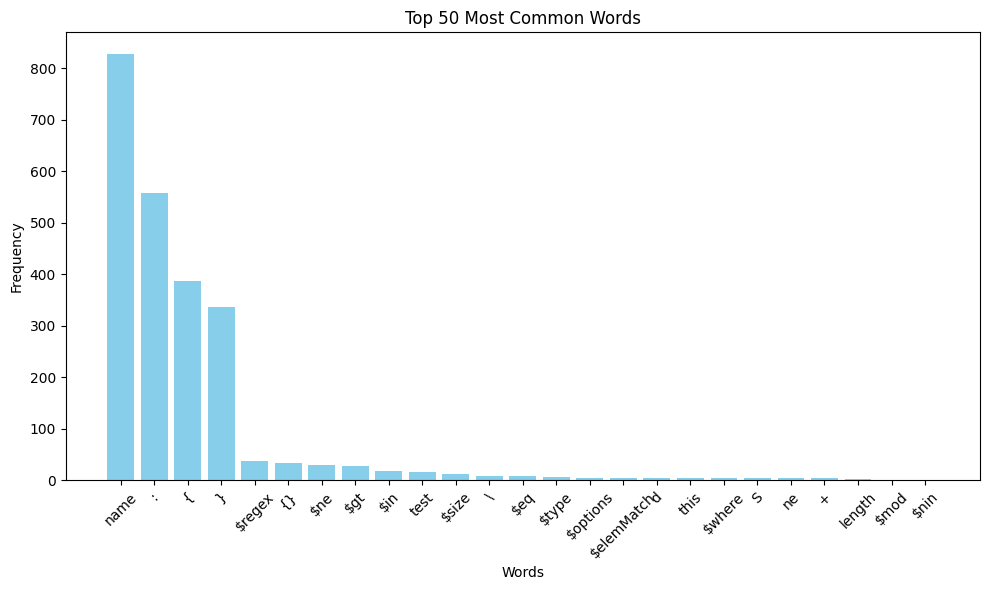

In [52]:
import re
from collections import Counter
import matplotlib.pyplot as plt

word_counts = Counter()
for text in data['denamed']:
    tokens = custom_tokenizer(text)
    word_counts.update(tokens)

# Convert the word counts to a DataFrame for easier manipulation
word_counts_df = pd.DataFrame.from_dict(word_counts, orient='index', columns=['Frequency'])

# Get the top 50 most common words
top_words = word_counts_df.sort_values(by='Frequency', ascending=False).head(50)

# Plot the top 50 most common words
plt.figure(figsize=(10, 6))
plt.bar(top_words.index, top_words['Frequency'], color='skyblue')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 50 Most Common Words')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Export word frequency data to a CSV file
word_counts_df.to_csv('wordFreqDN.csv', header=True)

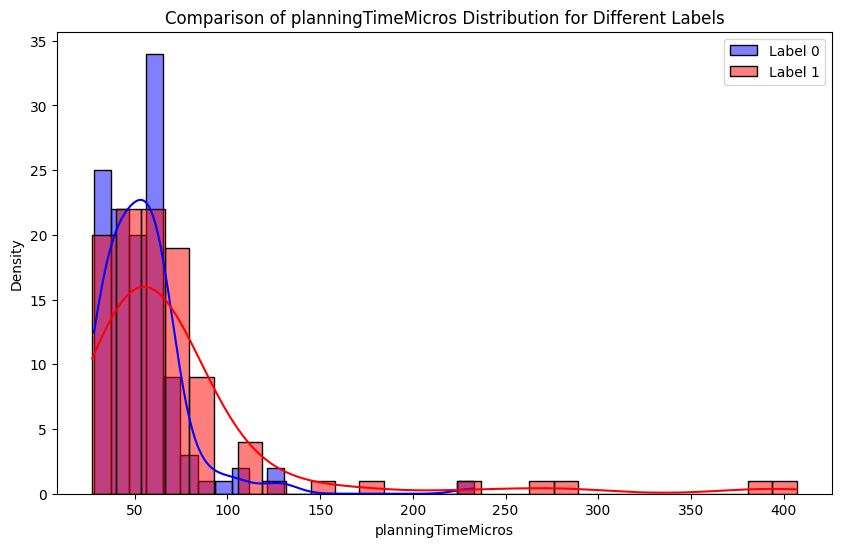

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter data based on label values
df_label_0 = data[data['label'] == 0]
df_label_1 = data[data['label'] == 1]

# Set up figure and axes
plt.figure(figsize=(10, 6))

# Plot query length distribution for both labels
sns.histplot(data=df_label_0, x='planningTimeMicros', color='blue', label='Label 0', kde=True)
sns.histplot(data=df_label_1, x='planningTimeMicros', color='red', label='Label 1', kde=True)

# Add labels and title
plt.title('Comparison of planningTimeMicros Distribution for Different Labels')
plt.xlabel('planningTimeMicros')
plt.ylabel('Density')

# Add legend
plt.legend()

# Show plot
plt.show()



In [7]:
from scipy.stats import f_oneway

# Perform ANOVA for 'cpuNanos'
anova_cpu = f_oneway(data[data['label'] == 0]['cpuNanos'],
                     data[data['label'] == 1]['cpuNanos'])

# Perform ANOVA for 'planningTimeMicros'
anova_planning = f_oneway(data[data['label'] == 0]['planningTimeMicros'],
                          data[data['label'] == 1]['planningTimeMicros'])

# Print ANOVA results
print("ANOVA for 'cpuNanos':")
print("F-statistic:", anova_cpu.statistic)
print("P-value:", anova_cpu.pvalue)
print("\nANOVA for 'planningTimeMicros':")
print("F-statistic:", anova_planning.statistic)
print("P-value:", anova_planning.pvalue)


ANOVA for 'cpuNanos':
F-statistic: 5.161096143621489
P-value: 0.024056409160643322

ANOVA for 'planningTimeMicros':
F-statistic: 9.102090237063472
P-value: 0.0028510150496943235


In [8]:
import pandas as pd
from scipy import stats

# Sample data
data_label_0_cpu = data[data['label'] == 0]['planningTimeMicros']
data_label_1_cpu = data[data['label'] == 1]['planningTimeMicros']

# Perform t-test
alpha_levels = [0.01, 0.05, 0.1]
t_test_results = []

for alpha in alpha_levels:
    t_statistic, p_value = stats.ttest_ind(data_label_0_cpu, data_label_1_cpu, equal_var=False)
    significant = p_value < alpha
    t_test_results.append({'Alpha': alpha, 'T-Statistic': t_statistic, 'P-Value': p_value, 'Significant': significant})

# Create DataFrame
df_t_test_results = pd.DataFrame(t_test_results)

# Display DataFrame
df_t_test_results


,Alpha,T-Statistic,P-Value,Significant
0,0.01,-2.864546,0.004862,True
1,0.05,-2.864546,0.004862,True
2,0.10,-2.864546,0.004862,True


In [9]:
import pandas as pd
from scipy.stats import mannwhitneyu

# Sample data
data_label_0_cpu = data[data['label'] == 0]['planningTimeMicros']
data_label_1_cpu = data[data['label'] == 1]['planningTimeMicros']

# Perform Mann-Whitney U test
alpha_levels = [0.01, 0.05, 0.1]
mannwhitneyu_results = []

for alpha in alpha_levels:
    statistic, p_value = mannwhitneyu(data_label_0_cpu, data_label_1_cpu, alternative='two-sided')
    significant = p_value < alpha
    mannwhitneyu_results.append({'Alpha': alpha, 'Statistic': statistic, 'P-Value': p_value, 'Significant': significant})

# Create DataFrame
df_mannwhitneyu_results = pd.DataFrame(mannwhitneyu_results)

# Display DataFrame
df_mannwhitneyu_results


,Alpha,Statistic,P-Value,Significant
0,0.01,4926.5,0.006628,True
1,0.05,4926.5,0.006628,True
2,0.10,4926.5,0.006628,True


In [10]:
from scipy.stats import ks_2samp

# Split data by label
data_label_0 = data[data['label'] == 0]['cpuNanos']
data_label_1 = data[data['label'] == 1]['cpuNanos']

# Perform Kolmogorov-Smirnov test
ks_statistic, p_value = ks_2samp(data_label_0, data_label_1)

# Print p-value
print("Kolmogorov-Smirnov test p-value:", p_value)


Kolmogorov-Smirnov test p-value: 0.025984925043869716


In [11]:
import pandas as pd
from scipy.stats import skew, kurtosis

# Calculate statistics for label 0
stats_label_0 = data[data['label'] == 0]['cpuNanos'].describe()
skewness_label_0 = skew(data[data['label'] == 0]['cpuNanos'])
kurtosis_label_0 = kurtosis(data[data['label'] == 0]['cpuNanos'])

# Calculate statistics for label 1
stats_label_1 = data[data['label'] == 1]['cpuNanos'].describe()
skewness_label_1 = skew(data[data['label'] == 1]['cpuNanos'])
kurtosis_label_1 = kurtosis(data[data['label'] == 1]['cpuNanos'])

# Combine statistics into a DataFrame
stats_df = pd.DataFrame({
    'Label 0': stats_label_0,
    'Label 1': stats_label_1
})

# Add skewness and kurtosis
stats_df.loc['Skewness'] = [skewness_label_0, skewness_label_1]
stats_df.loc['Kurtosis'] = [kurtosis_label_0, kurtosis_label_1]

# Print the DataFrame
stats_df


,Label 0,Label 1
count,120.000000,104.000000
mean,93480.683333,106751.576923
std,38591.197574,48755.307703
min,52048.000000,49784.000000
25%,69190.000000,72967.000000
50%,85741.000000,99327.000000
75%,110362.250000,124534.000000
max,345429.000000,378420.000000
Skewness,2.795571,2.499541
Kurtosis,13.917899,9.888758


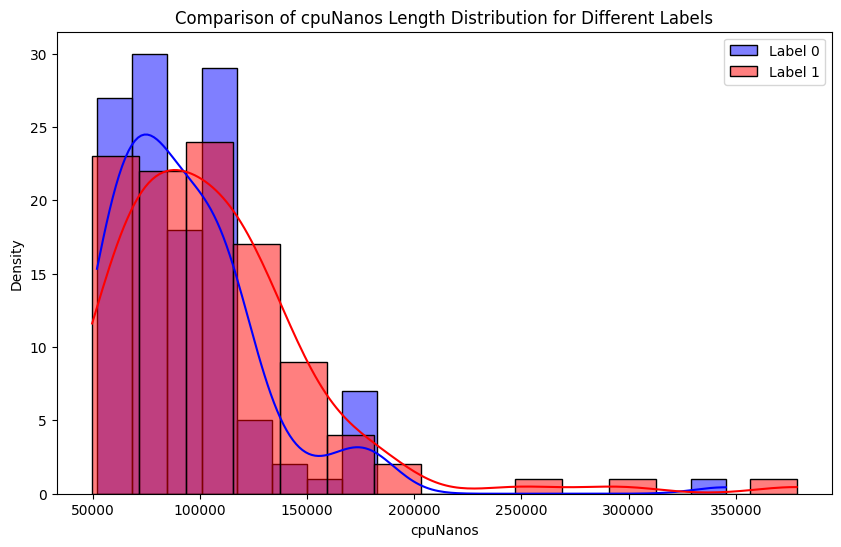

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter data based on label values
df_label_0 = data[data['label'] == 0]
df_label_1 = data[data['label'] == 1]

# Set up figure and axes
plt.figure(figsize=(10, 6))

# Plot query length distribution for both labels
sns.histplot(data=df_label_0, x='cpuNanos', color='blue', label='Label 0', kde=True)
sns.histplot(data=df_label_1, x='cpuNanos', color='red', label='Label 1', kde=True)

# Add labels and title
plt.title('Comparison of cpuNanos Length Distribution for Different Labels')
plt.xlabel('cpuNanos')
plt.ylabel('Density')

# Add legend
plt.legend()

# Show plot
plt.show()


In [13]:
import pandas as pd
from scipy import stats

# Sample data
data_label_0_cpu = data[data['label'] == 0]['cpuNanos']
data_label_1_cpu = data[data['label'] == 1]['cpuNanos']

# Perform t-test
alpha_levels = [0.01, 0.05, 0.1]
t_test_results = []

for alpha in alpha_levels:
    t_statistic, p_value = stats.ttest_ind(data_label_0_cpu, data_label_1_cpu, equal_var=False)
    significant = p_value < alpha
    t_test_results.append({'Alpha': alpha, 'T-Statistic': t_statistic, 'P-Value': p_value, 'Significant': significant})

# Create DataFrame
df_t_test_results = pd.DataFrame(t_test_results)

# Display DataFrame
df_t_test_results


,Alpha,T-Statistic,P-Value,Significant
0,0.01,-2.234676,0.026571,False
1,0.05,-2.234676,0.026571,True
2,0.10,-2.234676,0.026571,True


In [14]:
import pandas as pd
from scipy.stats import mannwhitneyu

# Sample data
data_label_0_cpu = data[data['label'] == 0]['cpuNanos']
data_label_1_cpu = data[data['label'] == 1]['cpuNanos']

# Perform Mann-Whitney U test
alpha_levels = [0.01, 0.05, 0.1]
mannwhitneyu_results = []

for alpha in alpha_levels:
    statistic, p_value = mannwhitneyu(data_label_0_cpu, data_label_1_cpu, alternative='two-sided')
    significant = p_value < alpha
    mannwhitneyu_results.append({'Alpha': alpha, 'Statistic': statistic, 'P-Value': p_value, 'Significant': significant})

# Create DataFrame
df_mannwhitneyu_results = pd.DataFrame(mannwhitneyu_results)

# Display DataFrame
df_mannwhitneyu_results


,Alpha,Statistic,P-Value,Significant
0,0.01,5013.0,0.011228,False
1,0.05,5013.0,0.011228,True
2,0.10,5013.0,0.011228,True


In [15]:
from scipy.stats import f_oneway

# Perform ANOVA for 'cpuNanos'
anova_cpu = f_oneway(data[data['label'] == 0]['cpuNanos'],
                     data[data['label'] == 1]['cpuNanos'])

# Perform ANOVA for 'planningTimeMicros'
anova_planning = f_oneway(data[data['label'] == 0]['planningTimeMicros'],
                          data[data['label'] == 1]['planningTimeMicros'])

# Print ANOVA results
print("ANOVA for 'cpuNanos':")
print("F-statistic:", anova_cpu.statistic)
print("P-value:", anova_cpu.pvalue)
print("\nANOVA for 'planningTimeMicros':")
print("F-statistic:", anova_planning.statistic)
print("P-value:", anova_planning.pvalue)


ANOVA for 'cpuNanos':
F-statistic: 5.161096143621489
P-value: 0.024056409160643322

ANOVA for 'planningTimeMicros':
F-statistic: 9.102090237063472
P-value: 0.0028510150496943235


In [16]:
import pandas as pd

# Define function to calculate conditional probabilities
def calculate_conditional_probabilities(data, feature, label_value):
    total_samples = len(data)
    feature_present = len(data[data[feature]])  # Number of samples where the feature is present
    feature_absent = total_samples - feature_present  # Number of samples where the feature is absent
    
    label_present = len(data[(data[feature]) & (data['label'] == label_value)])  # Number of samples where the feature is present and label is the specified value
    label_absent = feature_present - label_present  # Number of samples where the feature is present and label is not the specified value
    
    conditional_probability = label_present / feature_present  # P(label|feature)
    return conditional_probability

# Define boolean columns
bool_columns = ['whereDetected', 'regexDetected', 'emptyFilter', 'nullArgument', 'logicOperator']
conditional_probabilities = []

# Calculate conditional probabilities for each boolean column
for col in bool_columns:
    # Probability of label being 1 given the feature is present
    prob_label_1_given_present = calculate_conditional_probabilities(data, col, 1)
    
    # Probability of label being 1 given the feature is absent
    prob_label_1_given_absent = 1 - prob_label_1_given_present
    
    # Probability of label being 0 given the feature is present
    prob_label_0_given_present = calculate_conditional_probabilities(data, col, 0)
    
    # Probability of label being 0 given the feature is absent
    prob_label_0_given_absent = 1 - prob_label_0_given_present
    
    conditional_probabilities.append({'Feature': col,
                                      'P(Label=1|Feature=1)': prob_label_1_given_present,
                                      'P(Label=1|Feature=0)': prob_label_1_given_absent,
                                      'P(Label=0|Feature=1)': prob_label_0_given_present,
                                      'P(Label=0|Feature=0)': prob_label_0_given_absent})

# Create DataFrame from conditional probabilities
df_conditional_probabilities = pd.DataFrame(conditional_probabilities)

# Display DataFrame
df_conditional_probabilities


,Feature,P(Label=1|Feature=1),P(Label=1|Feature=0),P(Label=0|Feature=1),P(Label=0|Feature=0)
0,whereDetected,1.000000,0.000000,0.000000,1.000000
1,regexDetected,0.567568,0.432432,0.432432,0.567568
2,emptyFilter,0.000000,1.000000,1.000000,0.000000
3,nullArgument,0.653846,0.346154,0.346154,0.653846
4,logicOperator,0.562500,0.437500,0.437500,0.562500


In [17]:
from scipy.stats import pointbiserialr

# Define list to store correlation results
correlation_results = []

# Calculate correlation for each boolean column
for col in bool_columns:
    # Calculate correlation coefficient and p-value
    correlation, p_value = pointbiserialr(data[col], data['label'])
    
    # Append results to correlation_results list
    correlation_results.append({'Feature': col, 'Correlation': correlation, 'P-Value': p_value})

# Create DataFrame from correlation results
df_correlation_results = pd.DataFrame(correlation_results)

# Display DataFrame
print(df_correlation_results)


         Feature  Correlation   P-Value
0  whereDetected     0.144841  0.030227
1  regexDetected     0.092118  0.169471
2    emptyFilter    -0.154445  0.020751
3   nullArgument     0.137734  0.039426
4  logicOperator     0.146784  0.028057


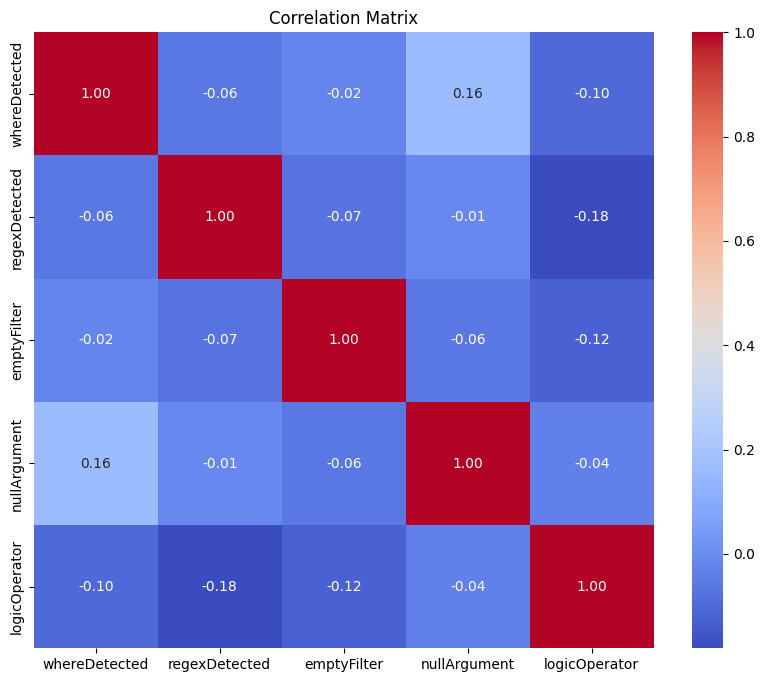

In [18]:
# Remove 'label' from bool_columns if it's included
if 'label' in bool_columns:
    bool_columns.remove('label')

# Calculate correlation matrix
correlation_matrix = data[bool_columns].corr()

# Plot correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()


In [19]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Initialize DataFrame to store VIF values
vif_values = []
bool_columns = ['whereDetected', 'regexDetected', 'emptyFilter', 'nullArgument', 'logicOperator']
for col in bool_columns:
    data[col] = data[col].astype(int)
# Iterate through boolean columns
for col in bool_columns:
    # Fit logistic regression model
    X = sm.add_constant(data[col])  # Add constant for intercept
    y = data['label']
    model = sm.Logit(y, X)
    result = model.fit()

    # Compute VIF
    vif = 1 / (1 - result.prsquared)
    
    # Append VIF to list
    vif_values.append({'Feature': col, 'VIF': vif})

# Create DataFrame from list of dictionaries
vif_data = pd.DataFrame(vif_values)

# Display DataFrame
print(vif_data)

         Current function value: 0.676706
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.686359
         Iterations 4
         Current function value: 0.673556
         Iterations: 35
Optimization terminated successfully.
         Current function value: 0.681053
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.679813
         Iterations 4
         Feature       VIF
0  whereDetected  1.020524
1  regexDetected  1.006170
2    emptyFilter  1.025295
3   nullArgument  1.014009
4  logicOperator  1.015858


/home/shaunakperni/.local/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/shaunakperni/.local/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [20]:
from scipy.stats import chi2_contingency

# Define boolean columns
bool_columns = ['whereDetected', 'regexDetected', 'emptyFilter', 'nullArgument', 'logicOperator']

# Initialize list to store chi-square test results
chi2_results = []

# Iterate through boolean columns
for col in bool_columns:
    # Create contingency table
    contingency_table = pd.crosstab(data[col], data['label'])
    
    # Perform chi-square test
    chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)
    
    # Append results to list
    chi2_results.append({'Feature': col, 'Chi-square Statistic': chi2_stat, 'P-value': p_value})

# Create DataFrame from list of dictionaries
chi2_results_df = pd.DataFrame(chi2_results)

# Display DataFrame
print(chi2_results_df)


         Feature  Chi-square Statistic   P-value
0  whereDetected              2.762145  0.096519
1  regexDetected              1.435939  0.230798
2    emptyFilter              3.597208  0.057877
3   nullArgument              3.430980  0.063984
4  logicOperator              4.231510  0.039680


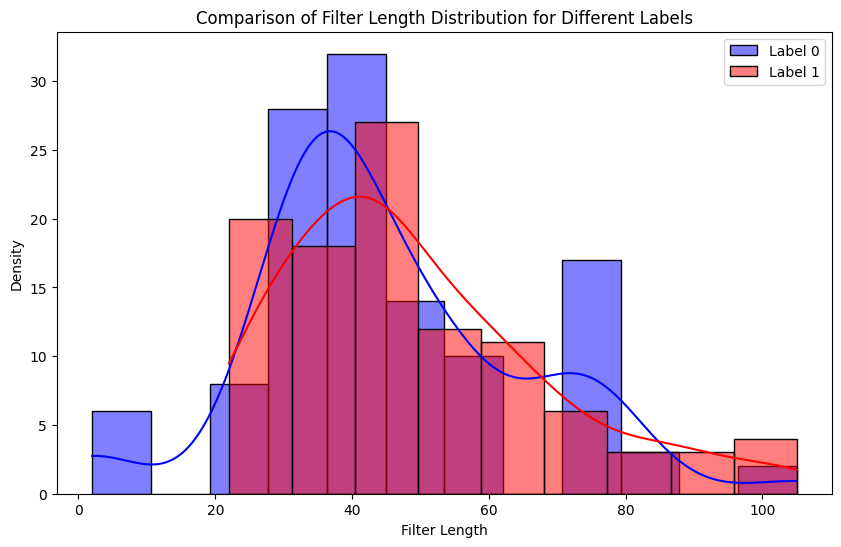

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter data based on label values
df_label_0 = data[data['label'] == 0]
df_label_1 = data[data['label'] == 1]

# Set up figure and axes
plt.figure(figsize=(10, 6))

# Plot query length distribution for both labels
sns.histplot(data=df_label_0, x='queryLength', color='blue', label='Label 0', kde=True)
sns.histplot(data=df_label_1, x='queryLength', color='red', label='Label 1', kde=True)

# Add labels and title
plt.title('Comparison of Filter Length Distribution for Different Labels')
plt.xlabel('Filter Length')
plt.ylabel('Density')

# Add legend
plt.legend()

# Show plot
plt.show()


In [22]:
import pandas as pd
from scipy import stats

# Sample data
data_label_0_cpu = data[data['label'] == 0]['queryLength']
data_label_1_cpu = data[data['label'] == 1]['queryLength']

# Perform t-test
alpha_levels = [0.01, 0.05, 0.1]
t_test_results = []

for alpha in alpha_levels:
    t_statistic, p_value = stats.ttest_ind(data_label_0_cpu, data_label_1_cpu, equal_var=False)
    significant = p_value < alpha
    t_test_results.append({'Alpha': alpha, 'T-Statistic': t_statistic, 'P-Value': p_value, 'Significant': significant})

# Create DataFrame
df_t_test_results = pd.DataFrame(t_test_results)

# Display DataFrame
df_t_test_results

,Alpha,T-Statistic,P-Value,Significant
0,0.01,-1.514076,0.13145,False
1,0.05,-1.514076,0.13145,False
2,0.10,-1.514076,0.13145,False


In [23]:
import pandas as pd
from scipy.stats import mannwhitneyu

# Sample data
data_label_0_cpu = data[data['label'] == 0]['queryLength']
data_label_1_cpu = data[data['label'] == 1]['queryLength']

# Perform Mann-Whitney U test
alpha_levels = [0.01, 0.05, 0.1]
mannwhitneyu_results = []

for alpha in alpha_levels:
    statistic, p_value = mannwhitneyu(data_label_0_cpu, data_label_1_cpu, alternative='two-sided')
    significant = p_value < alpha
    mannwhitneyu_results.append({'Alpha': alpha, 'Statistic': statistic, 'P-Value': p_value, 'Significant': significant})

# Create DataFrame
df_mannwhitneyu_results = pd.DataFrame(mannwhitneyu_results)

# Display DataFrame
df_mannwhitneyu_results


,Alpha,Statistic,P-Value,Significant
0,0.01,5589.0,0.178336,False
1,0.05,5589.0,0.178336,False
2,0.10,5589.0,0.178336,False


In [24]:
from scipy.stats import ks_2samp

# Split data by label
data_label_0 = data[data['label'] == 0]['queryLength']
data_label_1 = data[data['label'] == 1]['queryLength']

# Perform Kolmogorov-Smirnov test
ks_statistic, p_value = ks_2samp(data_label_0, data_label_1)

from scipy.stats import shapiro

# Perform Shapiro-Wilk test for each group
shapiro_stat_0, p_value_0 = shapiro(data_label_0)
shapiro_stat_1, p_value_1 = shapiro(data_label_1)

# Print p-values
print("Shapiro-Wilk test p-value for data_label_0:", p_value_0)
print("Shapiro-Wilk test p-value for data_label_1:", p_value_1)


Shapiro-Wilk test p-value for data_label_0: 3.344646393088624e-05
Shapiro-Wilk test p-value for data_label_1: 1.5999088645912707e-05


In [25]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import numpy as np
# Drop non-numeric columns that are not relevant for PCA and LDA
numeric_data = data.drop(columns=['filter_str', 'docUUID', 'denamed', 'FindCollectionTarget', 'FindCollectionTargetdeNamed',
                                  'db', 'denamedDb'])

# Encode boolean columns as integers
bool_columns = ['whereDetected', 'regexDetected', 'emptyFilter', 'nullArgument', 'logicOperator', 'label']
numeric_data[bool_columns] = numeric_data[bool_columns].astype(int)

# Separate features and target variable
X = numeric_data.drop(columns=['label'])
y = numeric_data['label']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform PCA for dimensionality reduction
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Perform LDA for dimensionality reduction
lda = LinearDiscriminantAnalysis(n_components=min(X_scaled.shape[1], len(np.unique(y)) - 1))
X_lda = lda.fit_transform(X_scaled, y)

# Print explained variance ratio for PCA
print("Explained Variance Ratio (PCA):", pca.explained_variance_ratio_)

# Print explained variance ratio for LDA
print("Explained Variance Ratio (LDA):", lda.explained_variance_ratio_)


Explained Variance Ratio (PCA): [0.24388091 0.22995608]
Explained Variance Ratio (LDA): [1.]


/tmp/ipykernel_147463/435783985.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['planningTimeMicros'] = scaler.fit_transform(X[['planningTimeMicros']])
/tmp/ipykernel_147463/435783985.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[['whereDetected', 'regexDetected', 'emptyFilter', 'nullArgument', 'logicOperator']] = X[['whereDetected', 'regexDetected', 'emptyFilter', 'nullArgument', 'logicOperator']].astype(int)


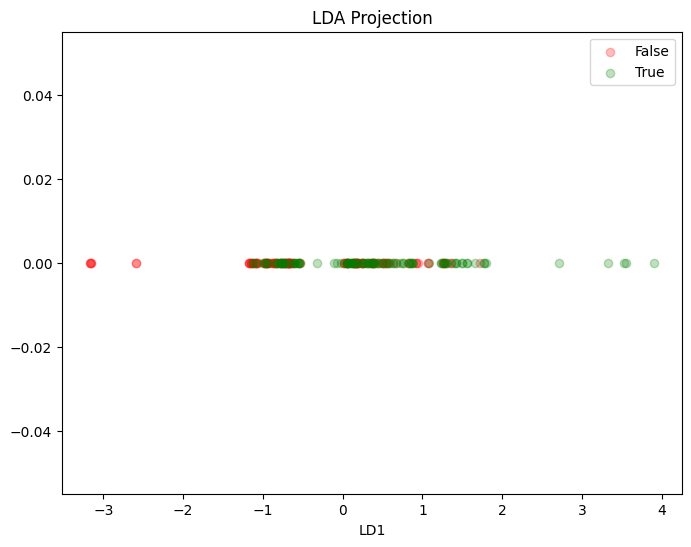

Explained Variance Ratio (LDA): [1.]
LDA Components:
[[ 0.65918202]
 [-0.28048859]
 [ 1.01860436]
 [-1.99326799]
 [ 1.3132358 ]
 [ 1.15641551]]


In [26]:
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import numpy as np
import matplotlib.pyplot as plt

# Separate features and target variable
X = data[['planningTimeMicros', 'whereDetected', 'regexDetected', 'emptyFilter', 'nullArgument', 'logicOperator']]
y = data['label']

# Standardize floating-point feature
scaler = StandardScaler()
X['planningTimeMicros'] = scaler.fit_transform(X[['planningTimeMicros']])

# Encode boolean features as integers
X[['whereDetected', 'regexDetected', 'emptyFilter', 'nullArgument', 'logicOperator']] = X[['whereDetected', 'regexDetected', 'emptyFilter', 'nullArgument', 'logicOperator']].astype(int)

# Perform LDA
lda = LinearDiscriminantAnalysis(n_components=min(X.shape[1], len(np.unique(y)) - 1))
X_lda = lda.fit_transform(X, y)

# Plot LDA
plt.figure(figsize=(8, 6))
targets = np.unique(y)
colors = ['r', 'g']  # Assuming binary target classes
for target, color in zip(targets, colors):
    plt.scatter(X_lda[y == target], np.zeros_like(X_lda[y == target]), c=color, label=target, alpha=0.25)
plt.xlabel('LD1')
plt.title('LDA Projection')
plt.legend()
plt.show()

# Return LDA results
print("Explained Variance Ratio (LDA):", lda.explained_variance_ratio_)

lda_components = lda.scalings_

print("LDA Components:")
print(lda_components)


Principal Component Labels:
Component 1: whereDetected, planningTimeMicros, nullArgument
Component 2: regexDetected, emptyFilter, nullArgument


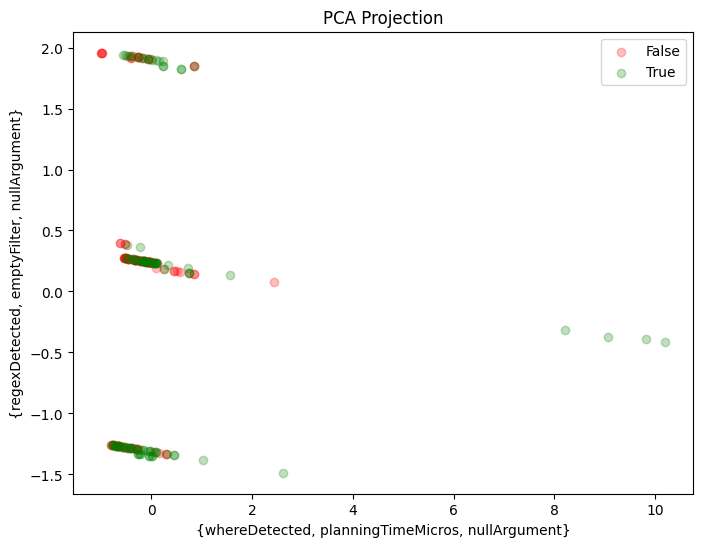

In [27]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.pyplot as plt

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform PCA for dimensionality reduction
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Get original feature names
feature_names = X.columns

# Get principal component loadings
component_loadings = pd.DataFrame(pca.components_, columns=feature_names)

# Label principal components based on loadings
component_labels = []
for i in range(len(component_loadings)):
    top_features = component_loadings.iloc[i].sort_values(ascending=False).index[:3]  # Top 3 features with highest loading
    component_labels.append(', '.join(top_features))

# Print component labels
print("Principal Component Labels:")
for i, label in enumerate(component_labels):
    print(f"Component {i+1}: {label}")

# Plot PCA with component names
plt.figure(figsize=(8, 6))
targets = np.unique(y)
colors = ['r', 'g']  # Assuming binary target classes

for target, color in zip(targets, colors):
    plt.scatter(X_pca[y == target, 0], X_pca[y == target, 1], c=color, label=target, alpha=0.25)  # Set alpha to 0.5 for transparency

plt.xlabel('{whereDetected, planningTimeMicros, nullArgument}')
plt.ylabel('{regexDetected, emptyFilter, nullArgument}')
plt.title('PCA Projection')
plt.legend()

plt.show()


t-SNE Transformed Coordinates:
[[-35.53207     14.503236  ]
 [-35.53207     14.503236  ]
 [ 23.08253     14.143166  ]
 [ 23.08253     14.143166  ]
 [-11.34475    -74.14572   ]
 [-11.34475    -74.14572   ]
 [ -8.616608   -71.2786    ]
 [ -8.616608   -71.2786    ]
 [ -1.4070481  -35.851543  ]
 [ -1.4070481  -35.851543  ]
 [  1.6976078   61.783737  ]
 [ -1.7189192   60.127724  ]
 [-11.861476    26.70812   ]
 [ -4.6114836   22.794441  ]
 [  5.6363726   -7.7542396 ]
 [  5.6363726   -7.7542396 ]
 [  5.6363726   -7.7542396 ]
 [ 14.76526    -67.62099   ]
 [ 14.76526    -67.62099   ]
 [ 18.828121   -84.54586   ]
 [ 22.880106   -82.64246   ]
 [-13.630002    83.33966   ]
 [-13.630002    83.33966   ]
 [-18.333393    82.72205   ]
 [ -9.170753    22.708904  ]
 [ -3.1167529   18.476717  ]
 [ 10.530276   -61.58616   ]
 [ 10.530276   -61.58616   ]
 [ 30.265903   -33.402683  ]
 [ 30.265903   -33.402683  ]
 [-24.40935     53.397568  ]
 [-24.40935     53.397568  ]
 [-17.335754    77.945786  ]
 [-17.335754

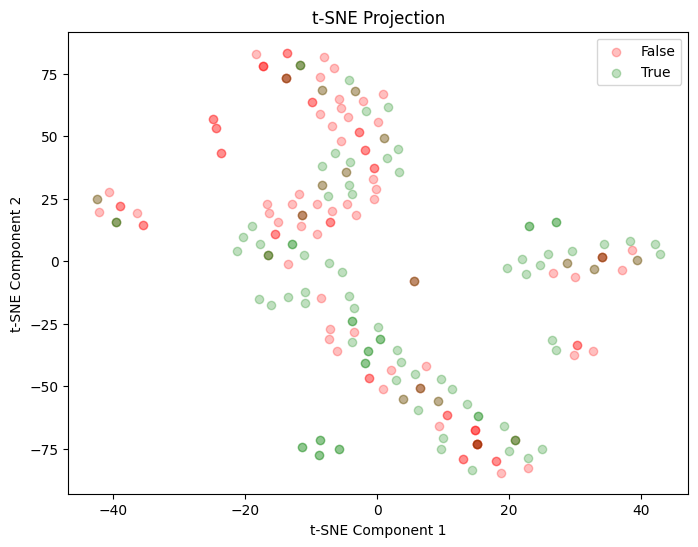

In [28]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)

# Print out the t-SNE transformed coordinates
print("t-SNE Transformed Coordinates:")
print(X_tsne)

# Plot the reduced-dimensional data
plt.figure(figsize=(8, 6))
targets = np.unique(y)
colors = ['r', 'g']  # Assuming binary target classes

for target, color in zip(targets, colors):
    plt.scatter(X_tsne[y == target, 0], X_tsne[y == target, 1], c=color, label=target, alpha=0.25)

plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE Projection')
plt.legend()
plt.show()


/home/shaunakperni/.local/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/shaunakperni/.local/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


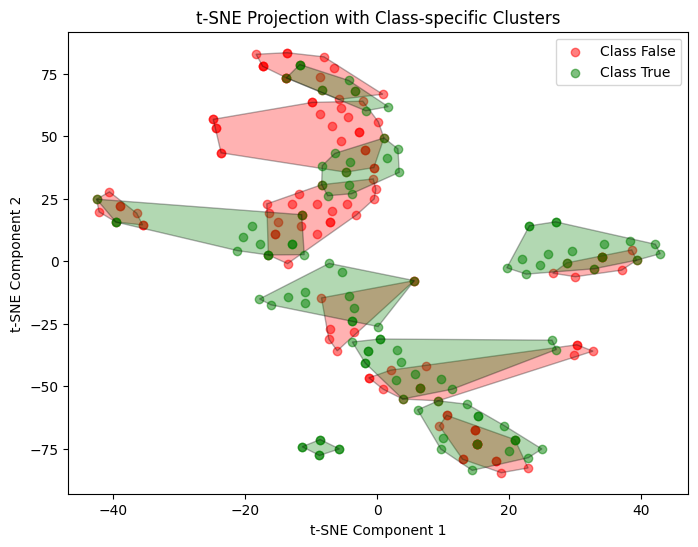

Overlapping Area: 0.0


In [29]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Polygon
from scipy.spatial import ConvexHull  # Import ConvexHull class
from shapely.geometry import Polygon as ShapelyPolygon

# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)

# Define the number of clusters for each class
num_clusters_per_class = 8

# Initialize a figure
plt.figure(figsize=(8, 6))

# Define colors for each class
class_colors = {0: 'red', 1: 'green'}  # Add more colors as needed

# List to store polygons
polygons = []

# Iterate over unique classes
for target_class in np.unique(y):
    # Filter the data points for the current class
    X_class = X_tsne[y == target_class]
    
    # Apply K-means clustering within the current class
    kmeans = KMeans(n_clusters=num_clusters_per_class, random_state=42)
    clusters = kmeans.fit_predict(X_class)
    
    # Plot the data points within the current class
    plt.scatter(X_class[:, 0], X_class[:, 1], label=f'Class {target_class}', color=class_colors[target_class], alpha=0.5)
    
    # Plot the polygons for each cluster
    for cluster in range(num_clusters_per_class):
        cluster_points = X_class[clusters == cluster]
        hull = ConvexHull(cluster_points)
        polygon = Polygon(cluster_points[hull.vertices], fill=True, edgecolor='black', facecolor=class_colors[target_class], alpha=0.3)  # Fill the area with class color
        plt.gca().add_patch(polygon)
        
        # Add polygon to the list
        polygons.append(ShapelyPolygon(cluster_points[hull.vertices]))

# Calculate overlapping area
overlapping_area = polygons[0].intersection(polygons[1]).area

# Set plot labels and title
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE Projection with Class-specific Clusters')

# Add legend
plt.legend()

# Show plot
plt.show()

print("Overlapping Area:", overlapping_area)


/home/shaunakperni/.local/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/shaunakperni/.local/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


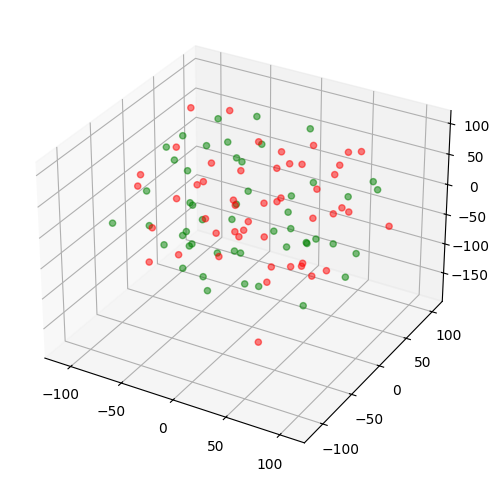

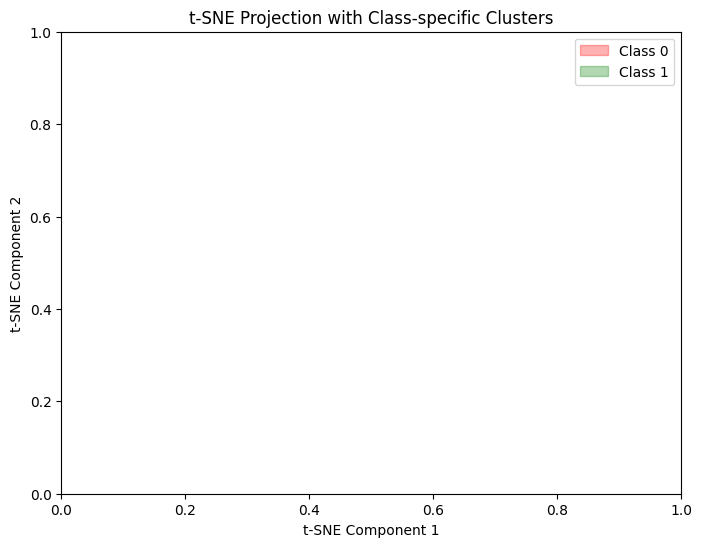

In [34]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Import Axes3D for 3D plotting
import numpy as np
from scipy.spatial import ConvexHull
from shapely.geometry import Polygon as ShapelyPolygon
from matplotlib.patches import Polygon

# Generate some sample data
np.random.seed(0)
X = np.random.randn(100, 3)  # 100 samples, 3 features
y = np.random.randint(0, 2, size=100)  # Random labels (0 or 1)

# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=3, random_state=42)
X_tsne = tsne.fit_transform(X)

# Define the number of clusters for each class
num_clusters_per_class = 8

# Initialize a figure
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')  # 3D plot

# Define colors for each class
class_colors = {0: 'red', 1: 'green'}  # Add more colors as needed

# List to store polygons
polygons = []

# Iterate over unique classes
for target_class in np.unique(y):
    # Filter the data points for the current class
    X_class = X_tsne[y == target_class]
    
    # Apply K-means clustering within the current class
    kmeans = KMeans(n_clusters=num_clusters_per_class, random_state=42)
    clusters = kmeans.fit_predict(X_class)
    
    # Plot the data points within the current class
    ax.scatter(X_class[:, 0], X_class[:, 1], X_class[:, 2], label=f'Class {target_class}', color=class_colors[target_class], alpha=0.5)
    
    # Plot the polygons for each cluster
    for cluster in range(num_clusters_per_class):
        cluster_points = X_class[clusters == cluster]
        hull = ConvexHull(cluster_points)
        # Project 3D points onto 2D for plotting
        cluster_points_2d = cluster_points[:, :2]
        polygon = Polygon(cluster_points_2d[hull.vertices], fill=True, edgecolor='black', facecolor=class_colors[target_class], alpha=0.3)  # Fill the area with class color
        polygons.append((polygon, target_class))  # Store the polygon and its class for later plotting

# Create a 2D plot for the polygons
fig2, ax2 = plt.subplots(figsize=(8, 6))

# Plot the polygons
for polygon, target_class in polygons:
    ax2.add_patch(polygon)

# Set plot labels and title
ax2.set_xlabel('t-SNE Component 1')
ax2.set_ylabel('t-SNE Component 2')
ax2.set_title('t-SNE Projection with Class-specific Clusters')

# Add legend
handles = [plt.Rectangle((0,0),1,1, color=class_colors[i], alpha=0.3, label=f'Class {i}') for i in range(2)]
ax2.legend(handles=handles, labels=['Class 0', 'Class 1'])

# Show plot
plt.show()


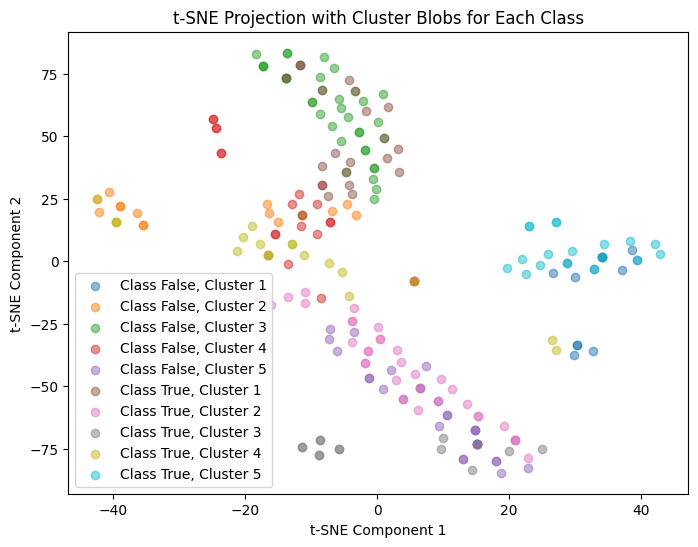

In [ ]:
from sklearn.manifold import TSNE
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)

# Get unique classes
unique_classes = np.unique(y)

# Plot the reduced-dimensional data with cluster blobs for each class
plt.figure(figsize=(8, 6))
for class_label in unique_classes:
    # Filter data points belonging to the current class
    X_class = X_tsne[y == class_label]
    
    # Apply Gaussian Mixture Model clustering for the current class
    gmm = GaussianMixture(n_components=5, random_state=42)
    gmm.fit(X_class)
    clusters = gmm.predict(X_class)
    
    # Plot cluster blobs for the current class
    for cluster in range(5):
        plt.scatter(X_class[clusters == cluster, 0], X_class[clusters == cluster, 1], label=f'Class {class_label}, Cluster {cluster + 1}', alpha=0.5)

plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE Projection with Cluster Blobs for Each Class')
plt.legend()
plt.show()


/home/shaunakperni/.local/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


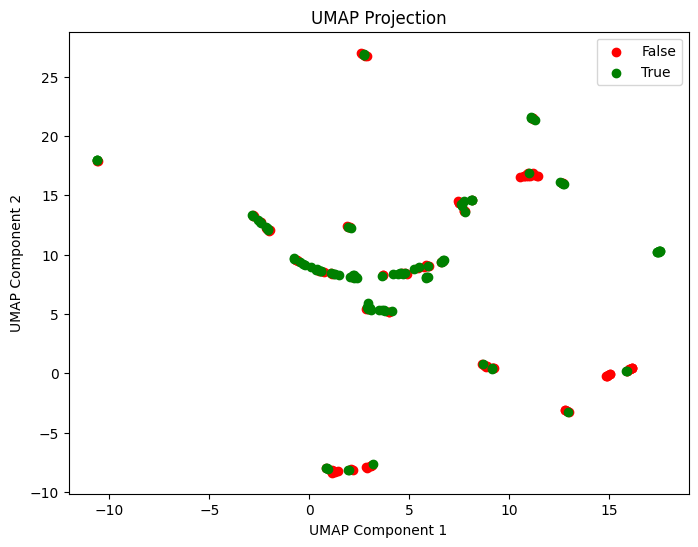

In [ ]:

import umap.umap_ as umap
import matplotlib.pyplot as plt

# Apply UMAP for dimensionality reduction
umap_model = umap.UMAP(n_components=2, random_state=42)
X_umap = umap_model.fit_transform(X)

# Plot the reduced-dimensional data
plt.figure(figsize=(8, 6))
targets = np.unique(y)
colors = ['r', 'g']  # Assuming binary target classes

for target, color in zip(targets, colors):
    plt.scatter(X_umap[y == target, 0], X_umap[y == target, 1], c=color, label=target)

plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.title('UMAP Projection')
plt.legend()
plt.show()


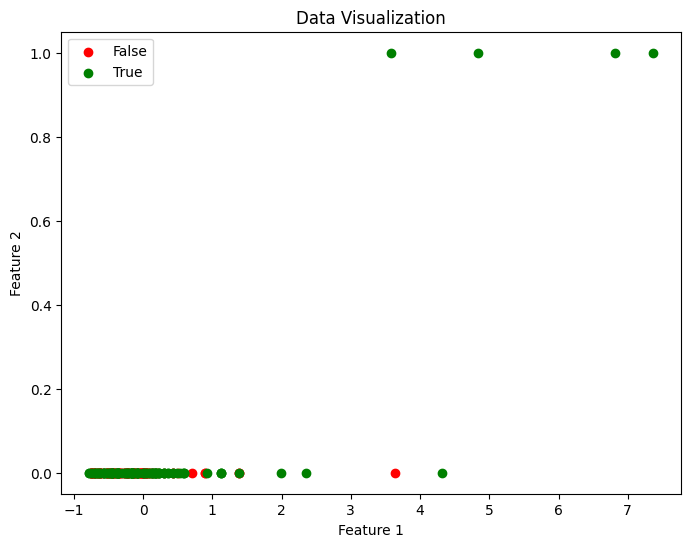

In [ ]:
import matplotlib.pyplot as plt

# Plot the data points
plt.figure(figsize=(8, 6))

# Assuming X is your DataFrame with boolean columns
# Assuming y is your target Series

targets = y.unique()
colors = ['r', 'g']  # Assuming binary target classes

for target, color in zip(targets, colors):
    plt.scatter(X[y == target].iloc[:, 0], X[y == target].iloc[:, 1], c=color, label=target)

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Data Visualization')
plt.legend()
plt.show()


RBF Kernel Matrix:
[[1.         1.         0.34435766 ... 0.09444489 0.08707763 0.0992431 ]
 [1.         1.         0.34435766 ... 0.09444489 0.08707763 0.0992431 ]
 [0.34435766 0.34435766 1.         ... 0.04426922 0.04218692 0.04550493]
 ...
 [0.09444489 0.09444489 0.04426922 ... 1.         0.99587886 0.99816628]
 [0.08707763 0.08707763 0.04218692 ... 0.99587886 1.         0.98859428]
 [0.0992431  0.0992431  0.04550493 ... 0.99816628 0.98859428 1.        ]]


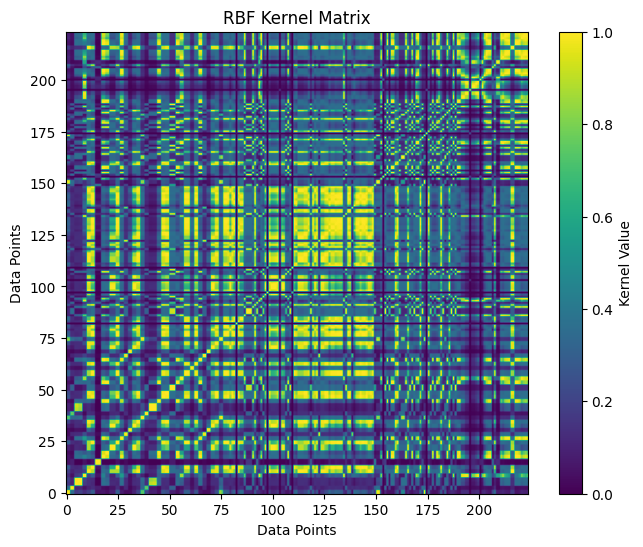

In [ ]:
from sklearn.metrics.pairwise import rbf_kernel
import numpy as np
import matplotlib.pyplot as plt

# Define RBF kernel parameters
gamma = 1.0  # You may need to adjust this parameter depending on your data

# Compute RBF kernel matrix
K = rbf_kernel(X, X, gamma=gamma)

# Print out the kernel values
print("RBF Kernel Matrix:")
print(K)

# Plot the kernel matrix
plt.figure(figsize=(8, 6))
plt.imshow(K, cmap='viridis', origin='lower')
plt.colorbar(label='Kernel Value')
plt.xlabel('Data Points')
plt.ylabel('Data Points')
plt.title('RBF Kernel Matrix')
plt.show()
